# Preference Attribute Analysis

In this notebook, we examine correlations and distributions over behavioural attributes.

In [13]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns
from src.viz.plot_config import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set seed
np.random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
CLUSTER_PATH = f"{PROJECT_ROOT}/results/clusters"
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/pref_attribute_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, models=False, metadata=False)

### Correlation of Attribute Scores

In [14]:
# Nested columns
survey = data_dict["survey"]
nested_columns = ["stated_prefs"]
survey = unnest_columns(survey, nested_columns)

# Stated pref columns
stated_pref_cols = [col for col in survey.columns if "stated_prefs" in col]


def get_corr_matrix(df, col_stub):
    if type(col_stub) == str:
        subset = df[
            [col for col in df.columns if col_stub in col and "other" not in col]
        ]

        subset.columns = [
            col.replace(f"{col_stub}", "").strip() for col in subset.columns
        ]

    elif type(col_stub) == list:
        subset = df[
            [
                col
                for col in df.columns
                if any([stub in col for stub in col_stub]) and "other" not in col
            ]
        ]

        new_cols = []
        for col in subset.columns:
            for stub in col_stub:
                if stub in col:
                    new_col = col.replace(f"{stub}", f"{stub[:-1]}: ").strip()
                    new_cols.append(new_col.replace("_", " "))
        subset.columns = new_cols

    # Calculate the correlation matrix
    correlations = subset.corr()

    return correlations


def plot_clustermap_by_multi_col(df, col_stub, figsize=(10, 5)):

    correlations = get_corr_matrix(df, col_stub)

    # Create the cluster map
    clustergrid = sns.clustermap(
        correlations,
        method="complete",
        cmap=palettes_dict["roma"].reversed(),
        annot=True,
        annot_kws={"size": 14},
        vmin=0,
        center=0.5,
        vmax=1,
        figsize=figsize,
        edgecolor="white",
        linewidth=1,
        cbar_pos=None,
        tree_kws={"linewidth": 4},
    )
    clustergrid.ax_col_dendrogram.set_visible(False)
    # Increase size of axis tick labels
    clustergrid.ax_heatmap.tick_params(axis="both", labelsize=20)

    plt.show()

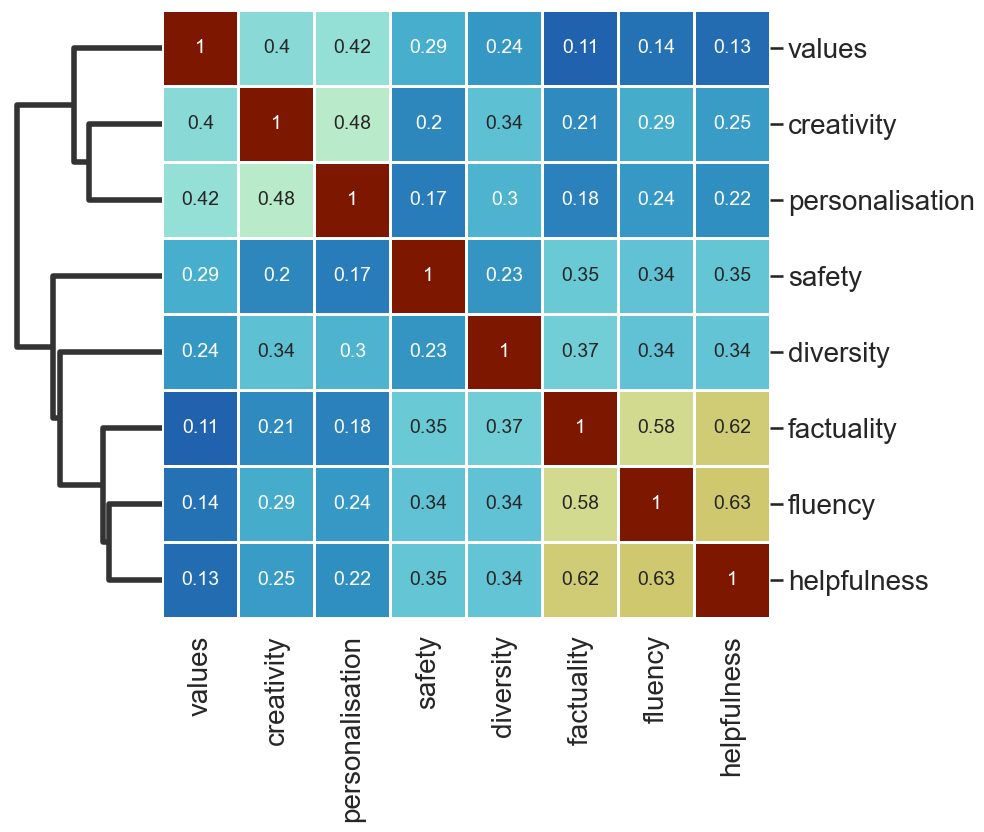

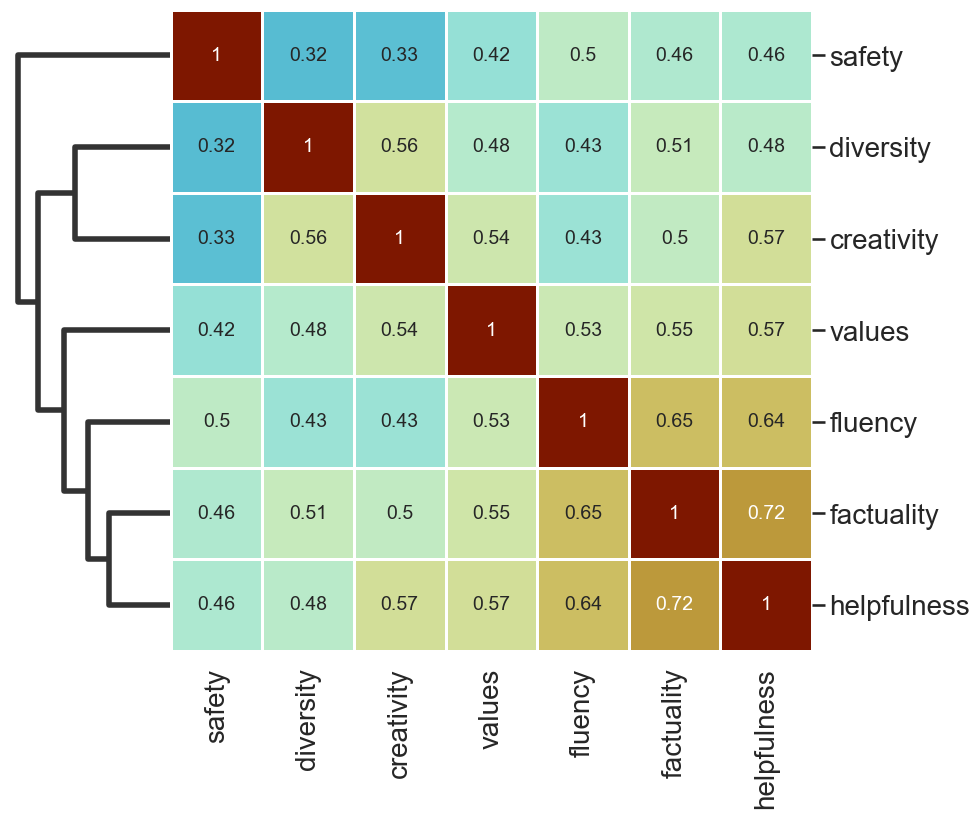

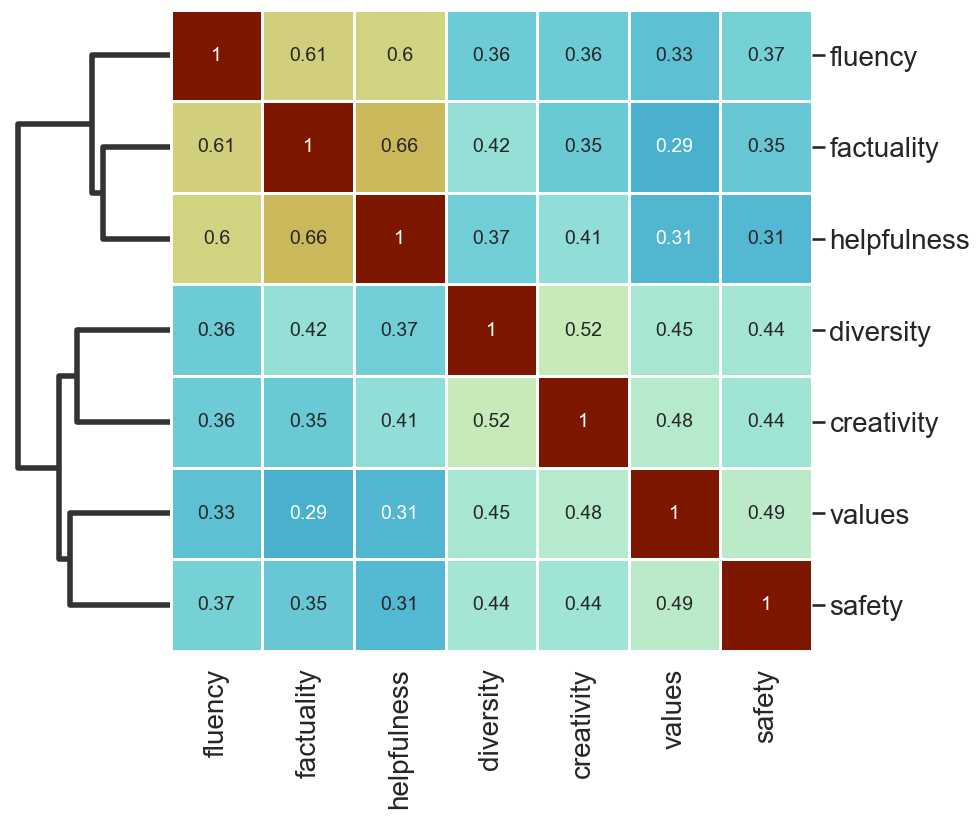

In [15]:
# Now plot with all three
dfs = ["survey", "conversations", "conversations"]
cols = ["stated_prefs", "performance_attributes", "choice_attributes"]

# Iterate over your dataframes and columns
for i, (df_name, col) in enumerate(zip(dfs, cols)):
    data = data_dict[df_name]
    data = unnest_columns(data, [col])
    col_stub = f"{col}_"
    correlations = get_corr_matrix(data, col_stub)
    plot_clustermap_by_multi_col(data, col_stub, figsize=(10, 10))

In [16]:
# Putting it together into one plot
convos = data_dict["conversations"]
survey = data_dict["survey"]
merged = pd.merge(convos, survey, on="user_id")
# Group by user_id and calculate means
cols = ["stated_prefs", "performance_attributes", "choice_attributes"]
col_stubs = [f"{col}_" for col in cols]
merged = unnest_columns(merged, cols)
all_cols = [
    col
    for col in merged.columns
    if any([stub in col for stub in col_stubs]) and "other" not in col
]
subset = merged[["user_id"] + all_cols]
grouped = subset.groupby("user_id").mean().reset_index()
col_stubs = [f"{col}_" for col in cols]

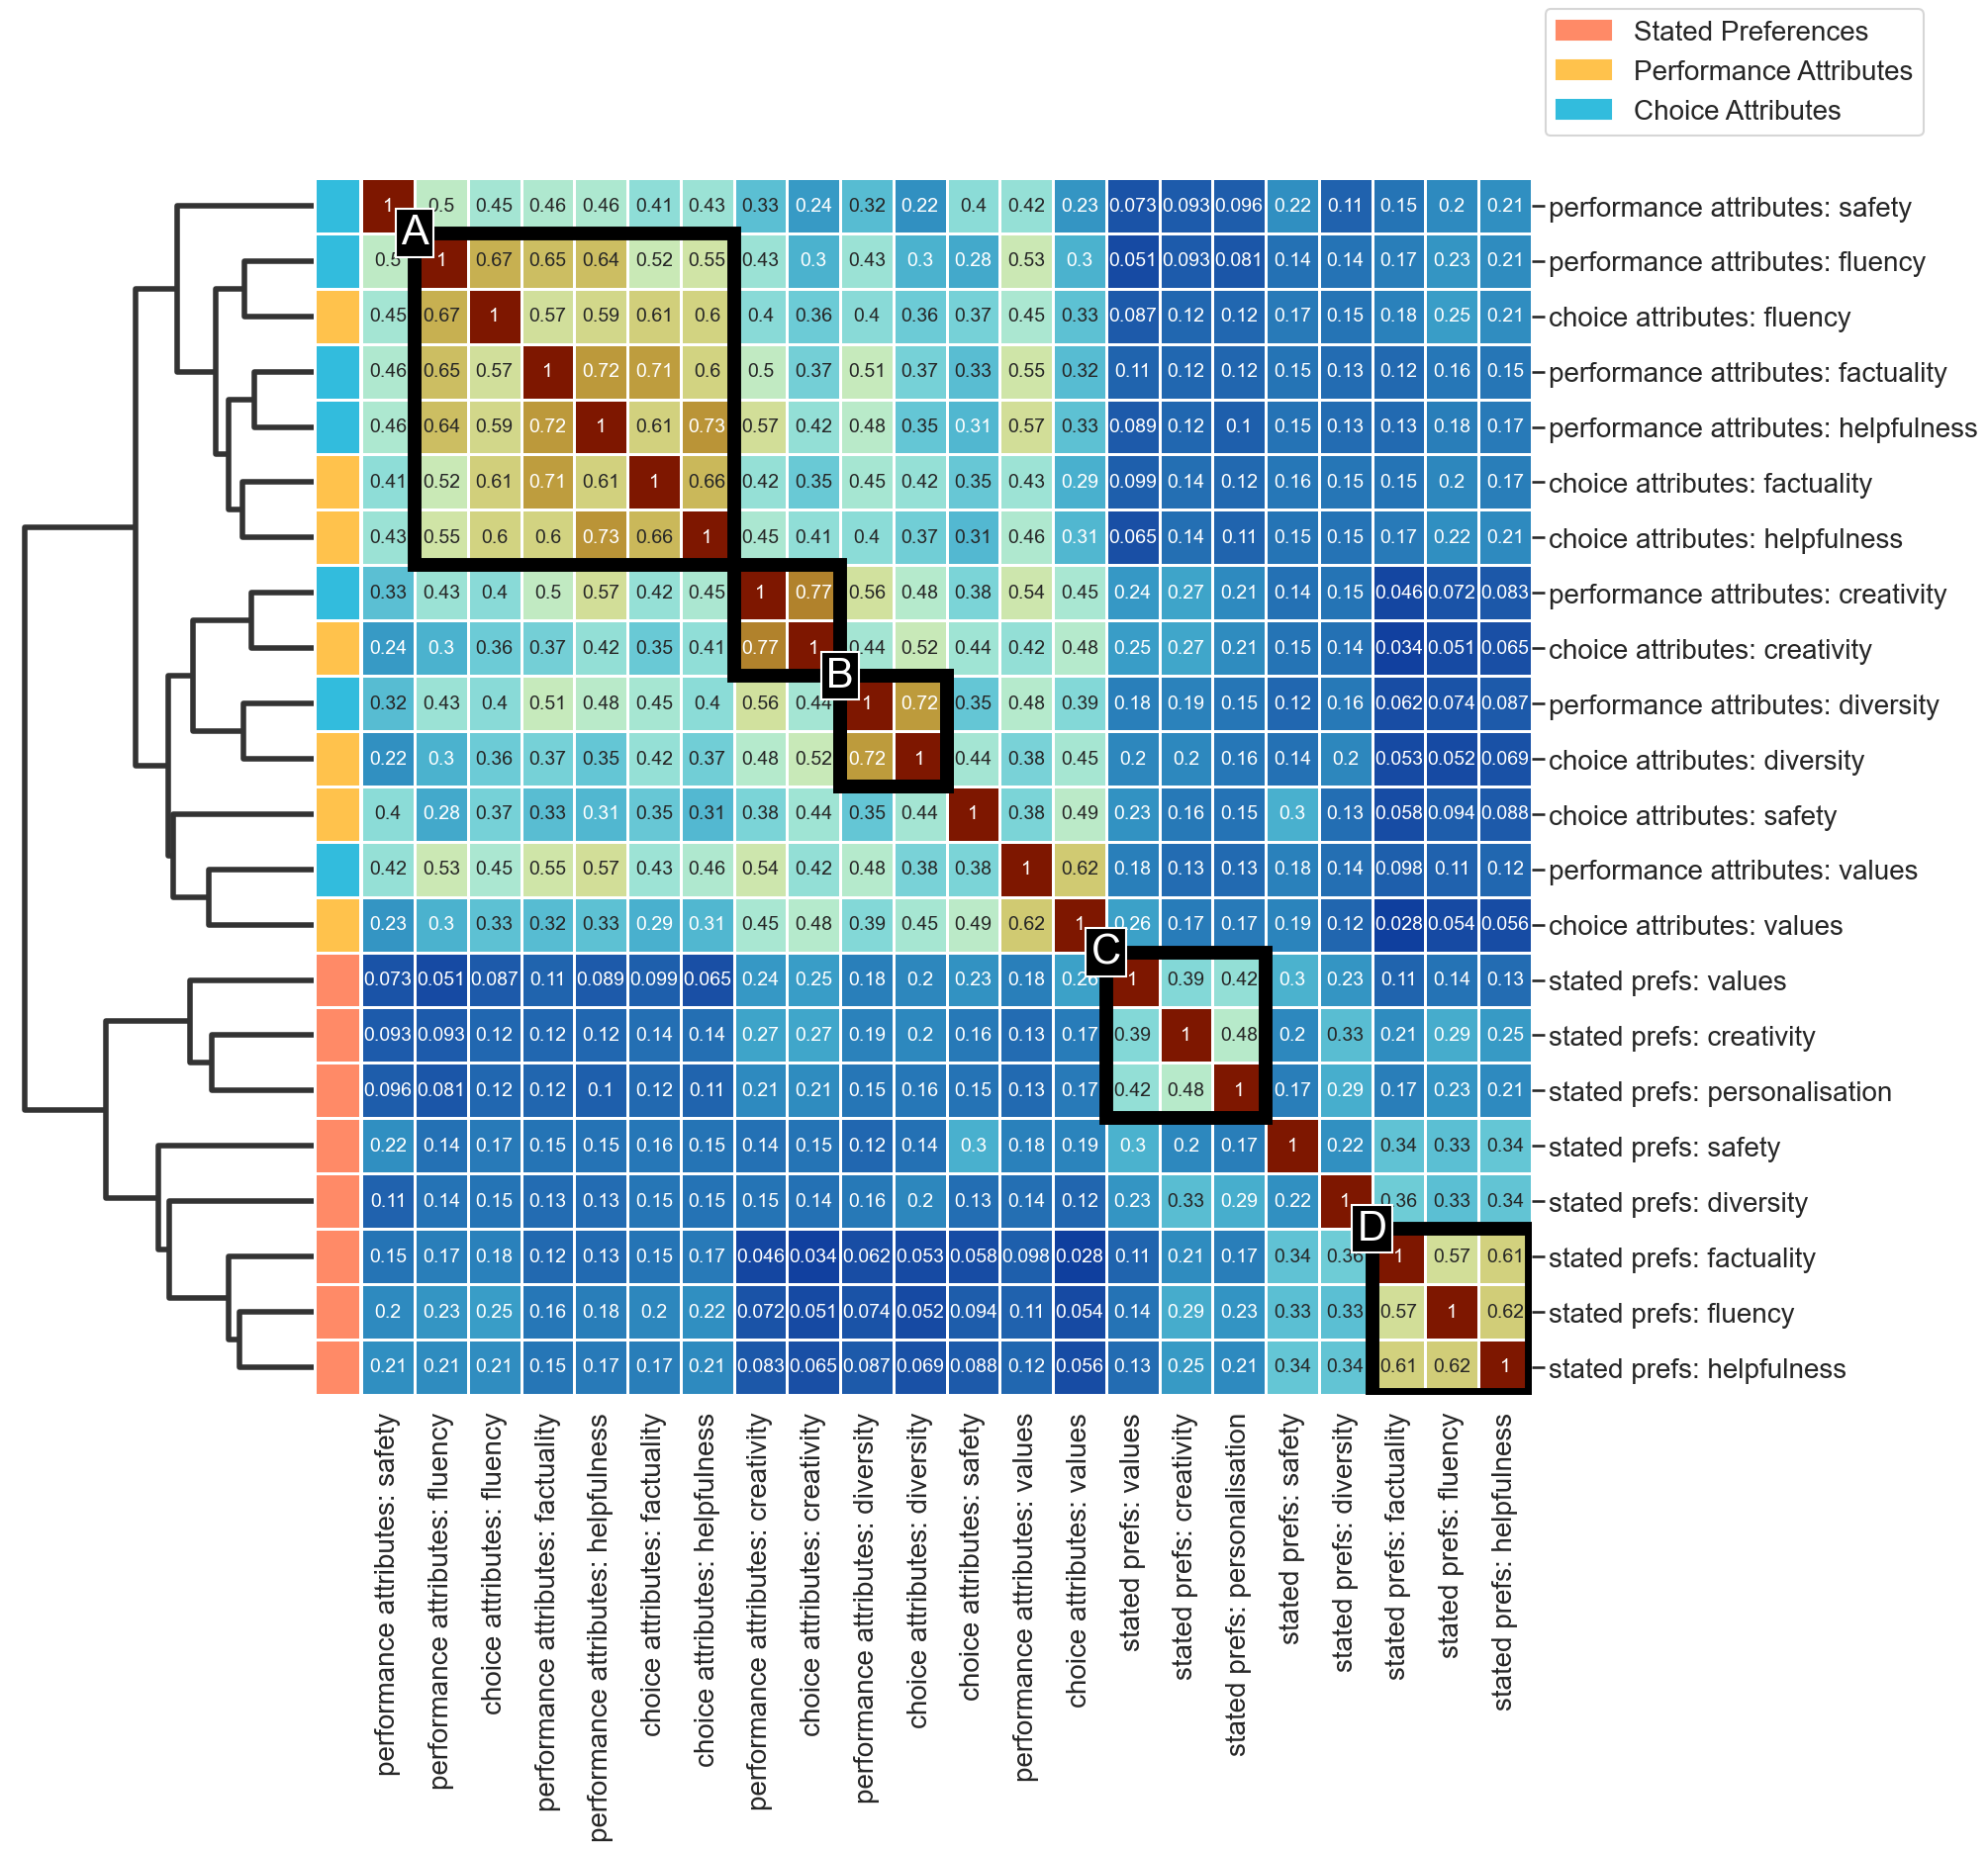

In [17]:
correlations = get_corr_matrix(merged, col_stubs)
figsize = (20, 20)

# Set row colors based on col stub (before :)
row_colors = []
for col in correlations.columns:
    if "stated" in col:
        row_colors.append(basic_colors_dict["red"])
    elif "performance" in col:
        row_colors.append(basic_colors_dict["blue"])
    elif "choice" in col:
        row_colors.append(basic_colors_dict["yellow"])

# Create the cluster map
clustergrid = sns.clustermap(
    correlations,
    method="complete",
    cmap=palettes_dict["roma"].reversed(),
    annot=True,
    annot_kws={"size": 14},
    vmin=0,
    center=0.5,
    vmax=1,
    figsize=figsize,
    edgecolor="white",
    linewidth=1,
    cbar_pos=None,
    tree_kws={"linewidth": 4},
    row_cluster=True,
    row_colors=row_colors,
)
clustergrid.ax_col_dendrogram.set_visible(False)
# Increase size of axis tick labels
clustergrid.ax_heatmap.tick_params(axis="both", labelsize=20)
# Add legend
red_patch = mpatches.Patch(color=basic_colors_dict["red"], label="Stated Preferences")
yellow_patch = mpatches.Patch(
    color=basic_colors_dict["yellow"], label="Performance Attributes"
)
blue_patch = mpatches.Patch(color=basic_colors_dict["blue"], label="Choice Attributes")
plt.legend(
    handles=[red_patch, yellow_patch, blue_patch],
    loc="upper left",
    fontsize=20,
    bbox_to_anchor=(1, 1.15),
)

# Draw a box around the 'objective' measure cluster
rect = mpatches.Rectangle((1, 1), 6, 6, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.text(
    1,
    1,
    "A",
    fontsize=30,
    ha="center",
    va="center",
    color="white",
    bbox=dict(facecolor="black", alpha=1),
)
clustergrid.ax_heatmap.add_patch(rect)

# Draw a box around the small blocks of correlated choice:performance
rect = mpatches.Rectangle((7, 7), 2, 2, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.text(
    9,
    9,
    "B",
    fontsize=30,
    ha="center",
    va="center",
    color="white",
    bbox=dict(facecolor="black", alpha=1),
)
clustergrid.ax_heatmap.add_patch(rect)
rect = mpatches.Rectangle((9, 9), 2, 2, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.add_patch(rect)

# Draw a box the 'subjective' measure cluster for stated prefs
rect = mpatches.Rectangle((14, 14), 3, 3, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.text(
    14,
    14,
    "C",
    fontsize=30,
    ha="center",
    va="center",
    color="white",
    bbox=dict(facecolor="black", alpha=1),
)
clustergrid.ax_heatmap.add_patch(rect)
rect = mpatches.Rectangle((9, 9), 2, 2, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.add_patch(rect)

# Draw a box the 'objective' measure cluster for stated prefs
rect = mpatches.Rectangle((19, 19), 3, 3, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.text(
    19,
    19,
    "D",
    fontsize=30,
    ha="center",
    va="center",
    color="white",
    bbox=dict(facecolor="black", alpha=1),
)
clustergrid.ax_heatmap.add_patch(rect)
rect = mpatches.Rectangle((9, 9), 2, 2, fill=False, edgecolor="black", linewidth=10)
clustergrid.ax_heatmap.add_patch(rect)

plt.show()

# Save the plot
clustergrid.savefig(
    f"{PLOT_PATH}/clustermap_attributes.pdf", bbox_inches="tight", format="pdf"
)

## Distribution of Attribute Scores

In [18]:
def extract_values(df, col_stub, col_type):
    selected_cols = [col for col in df.columns if col.startswith(f"{col_stub}_")]
    # Sort selected_cols alphabetically
    selected_cols.sort(reverse=True)
    # Remove personalisation columns and make sure these are at the end (only appear in survey)
    shared_cols = [col for col in selected_cols if "personalisation" not in col]
    personalisation_cols = [col for col in selected_cols if "personalisation" in col]
    selected_cols = shared_cols + personalisation_cols

    values_store = {}
    for col in selected_cols:
        if "other" in col:
            continue
        else:
            if col_type == "discrete":
                count = len(df[df[col] == 1])
                mapped_col = col.split("_")[-1]
                values_store[mapped_col] = count

            elif col_type == "continuous":
                array = [int(v) if not pd.isna(v) else v for v in df[col].to_list()]
                mapped_col = col.split("_")[-1]
                values_store[mapped_col] = array
    return values_store

In [19]:
def plot_box_from_multi_col(
    df, title, col_stub, edge_names, figsize=(10, 6), plot_type="box"
):
    value_array_dict = extract_values(df, col_stub, "continuous")

    labels = list(value_array_dict.keys())
    values = list(value_array_dict.values())

    df_temp = pd.DataFrame({label: value for label, value in zip(labels, values)})
    df_melted = df_temp.melt(var_name="Label", value_name="Value")

    if "personalisation" in labels:
        n_colors = len(labels) - 1
    else:
        n_colors = len(labels)

    color_palette = get_equally_spaced_colors(palettes_dict["roma"], n_colors)
    if "personalisation" in labels:
        color_palette.append("grey")

    plt.figure(figsize=figsize)
    plt.axhline(y=100, color="grey", linestyle="-", alpha=0.4)
    pad = 1.5
    plt.text(
        -0.45,
        100 + pad,
        edge_names[1],
        fontsize=14,
        fontweight="semibold",
        va="bottom",
        ha="left",
        bbox=dict(
            facecolor=basic_colors_dict["oat"], edgecolor="none", pad=1, alpha=0.8
        ),
    )

    plt.axhline(y=0, color="grey", linestyle="-", alpha=0.4)
    plt.text(
        -0.45,
        0 - pad,
        edge_names[0],
        fontsize=14,
        fontweight="semibold",
        va="top",
        ha="left",
        bbox=dict(facecolor="white", edgecolor="none", pad=1, alpha=0.8),
    )

    # Plot each boxplot individually
    for i, label in enumerate(labels):
        # Filter data for the current label
        label_data = df_melted[df_melted["Label"] == label]["Value"]

        if plot_type == "box":
            sns.boxplot(
                x="Label",
                y="Value",
                data=df_melted[df_melted["Label"] == label],
                color=color_palette[i],
                linewidth=1.5,
                flierprops=dict(
                    marker="o",
                    markerfacecolor=color_palette[i],
                    alpha=0.5,
                ),
                # position=[i]
            )

        elif plot_type == "violin":
            sns.violinplot(
                x="Label",
                y="Value",
                data=df_melted[df_melted["Label"] == label],
                color=color_palette[i],
                linewidth=1.5,
                # position=[i]
            )

        # Calculate Q1, median, Q3
        Q1 = label_data.quantile(0.25)
        median = label_data.quantile(0.5)
        Q3 = label_data.quantile(0.75)

        # Place text labels
        plt.text(
            i,
            median,
            f"{median:.0f}",
            va="center",
            ha="center",
            fontsize=12,
            color=color_palette[i],
            bbox=dict(facecolor="white", edgecolor="none", pad=1),
        )

    # Reduce size of ticks for this plot
    plt.ylim([-10, 110])
    plt.yticks(fontsize=12)
    plt.xticks(range(len(labels)), labels, fontweight="semibold", fontsize=13)
    plt.ylabel("")
    plt.xlabel("")
    # plt.title(title)

    # Save
    plt.savefig(
        f"{PLOT_PATH}/single_dist_{col_stub}.pdf", bbox_inches="tight", format="pdf"
    )

    plt.show()

    return values, labels

#### Individual Plots

In [20]:
df = merged.copy()

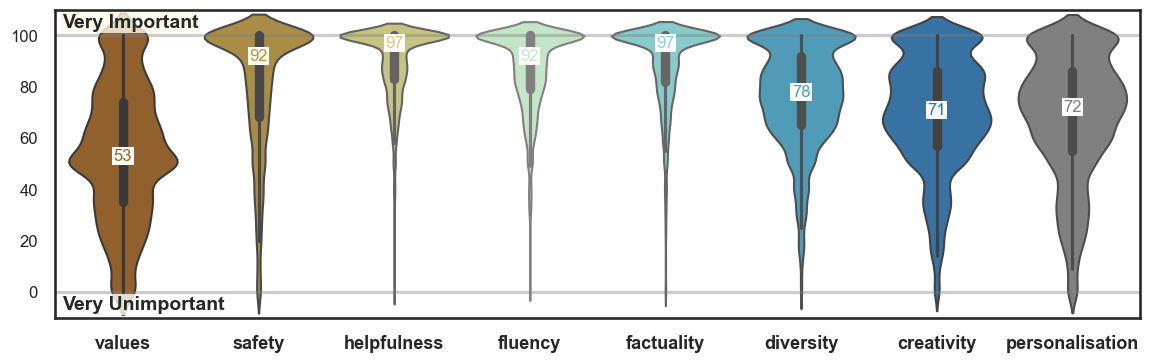

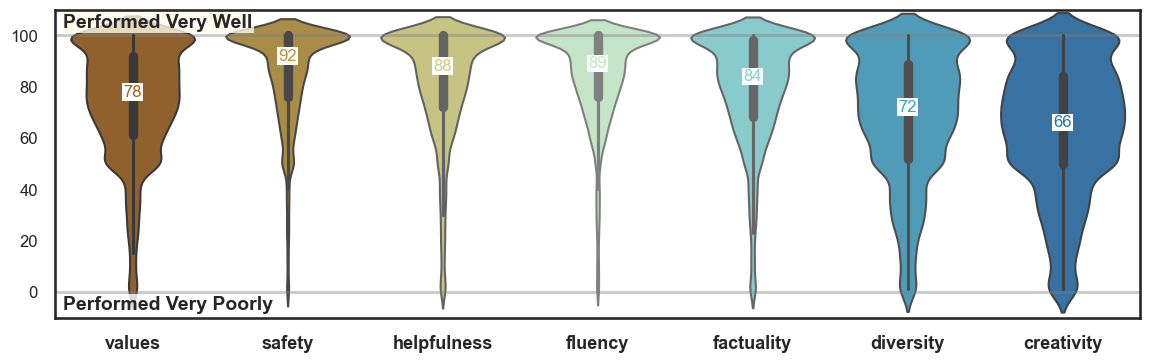

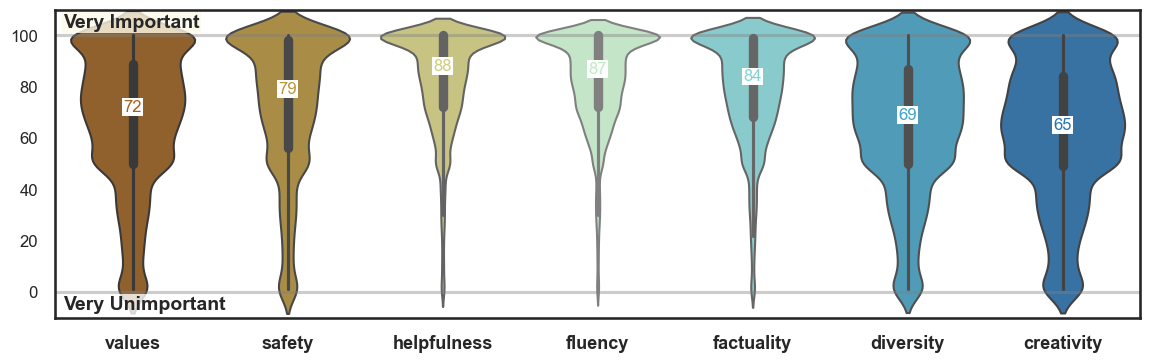

In [21]:
title = "Individual preference for attributes of language model behaviours"
_, _ = plot_box_from_multi_col(
    df,
    title,
    "stated_prefs",
    ["Very Unimportant", "Very Important"],
    figsize=(14, 4),
    plot_type="violin",
)

title = "Model performance by behaviour attribute in context"
values, labels = plot_box_from_multi_col(
    df,
    title,
    "performance_attributes",
    ["Performed Very Poorly", "Performed Very Well"],
    figsize=(14, 4),
    plot_type="violin",
)

title = "Importance of behaviour attribute for determing preference in context"
values, labels = plot_box_from_multi_col(
    df,
    title,
    "choice_attributes",
    ["Very Unimportant", "Very Important"],
    figsize=(14, 4),
    plot_type="violin",
)

#### Combined Plot

In [23]:
def plot_box_combined_with_nans(df_dict, title, legend_dict, figsize, plot_type="box"):
    combined_df = pd.DataFrame()
    nan_counts_dict = {}

    for col_grper, df in df_dict.items():
        value_array_dict = extract_values(df, col_grper, "continuous")
        labels = list(value_array_dict.keys())
        values = list(value_array_dict.values())

        df_temp = pd.DataFrame({label: value for label, value in zip(labels, values)})
        df_melted = df_temp.melt(var_name="Label", value_name="Value")
        df_melted["Attribute"] = col_grper  # Add a new column for category
        df_melted.reset_index(drop=True, inplace=True)
        combined_df = pd.concat([combined_df, df_melted])

        # Calculate NaN counts for each label in the current category
        nan_counts_dict[col_grper] = (df_temp.isna().sum() / len(df_temp)) * 100

    combined_df.reset_index(drop=True, inplace=True)

    # Set up fig
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(5, 1, figure=fig, hspace=0.0)
    ax = fig.add_subplot(gs[:4, 0])

    # Axlines
    ax.axhline(y=100, color="grey", linestyle="-", alpha=0.4)

    # Set colors
    color_palette = list(basic_colors_dict.values())[0:3]

    ### BOX PLOT ###
    if plot_type == "box":
        sns.boxplot(
            ax=ax,
            x="Label",
            y="Value",
            hue="Attribute",
            data=combined_df,
            palette=color_palette,
            dodge=True,
            boxprops=dict(alpha=1),
            gap=0.1,
            linewidth=1.5,
            # adjust median line to '--'
            medianprops=dict(linestyle="--", linewidth=1.5),
            flierprops=dict(
                marker="o",
                markerfacecolor="grey",
                markeredgecolor=basic_colors_dict["light_grey"],
                alpha=0.2,
            ),
        )

        # Iterate over the lines in the box plot and find the medians
        for line in ax.lines:
            # Check if the line is a median line
            if line.get_linestyle() == "--":
                # Get the x and y data points of the median line
                x_data, y_data = line.get_data()
                # Calculate the median value (y-coordinate)
                median_value = y_data[0]
                x_position = (x_data[0] + x_data[1]) / 2
                # Add a text annotation with the median value
                ax.text(
                    x_position,
                    median_value,
                    f"{median_value:.0f}",
                    verticalalignment="center",
                    horizontalalignment="center",
                    color="grey",
                    fontsize=14,
                    weight="bold",
                    bbox=dict(facecolor="white", edgecolor="none", pad=1, alpha=0.8),
                )

    #### VIOLIN PLOT ####
    elif plot_type == "violin":
        ax = sns.violinplot(
            x="Label",
            y="Value",
            hue="Attribute",
            data=combined_df,
            palette=color_palette,
            gap=-0.5,
            linewidth=0.5,
            inner="quartile",
            inner_kws=dict(color="grey", linewidth=1.5),
            alpha=0.5,
        )

    # Legend
    legend_handles = [
        mpatches.Patch(color=color_palette[i], label=label)
        for i, label in enumerate(legend_dict.values())
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.5),
        fontsize=14,
        fancybox=True,
        ncol=len(legend_dict),
    )

    # Reduce size of ticks for this plot
    ax.set_ylim([-10, 110])
    ax.tick_params(axis="x", which="major", pad=10)
    ax.tick_params(axis="y", which="major", pad=0)
    ax.set_xticklabels(labels, fontweight="semibold", fontsize=13)
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Bar chart axes
    ax2 = fig.add_subplot(gs[4, 0])

    # Plot the bar chart for NaN counts
    nan_counts_df = pd.DataFrame(nan_counts_dict)
    df_melted = nan_counts_df.reset_index().melt(
        id_vars="index", var_name="Attribute", value_name="Count"
    )
    df_melted.rename(columns={"index": "Category"}, inplace=True)
    sns.barplot(
        data=df_melted,
        x="Category",
        y="Count",
        hue="Attribute",
        alpha=0.8,
        ax=ax2,
        palette=color_palette,
        legend=False,
    )
    ax2.bar_label(
        ax2.containers[0], fontsize=10, fmt="%.0f", label_type="edge", padding=0.5
    )
    ax2.bar_label(
        ax2.containers[1], fontsize=10, fmt="%.0f", label_type="edge", padding=0.5
    )
    ax2.bar_label(
        ax2.containers[2], fontsize=10, fmt="%.0f", label_type="edge", padding=0.5
    )
    ax2.set_ylabel("% NA", fontsize=12, rotation=90)
    ax2.set_ylim(0, 16)
    ax2.set_xlabel("")
    # Turn off ax2 labels
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.set_xticklabels(labels, fontweight="semibold", fontsize=13)

    # Save
    plt.savefig(
        f"{PLOT_PATH}/combined_dist_attributes_{plot_type}.pdf",
        bbox_inches="tight",
        format="pdf",
    )

    plt.show()

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_68248/2855093761.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontweight="semibold", fontsize=13)
/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_68248/2855093761.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, fontweight="semibold", fontsize=13)


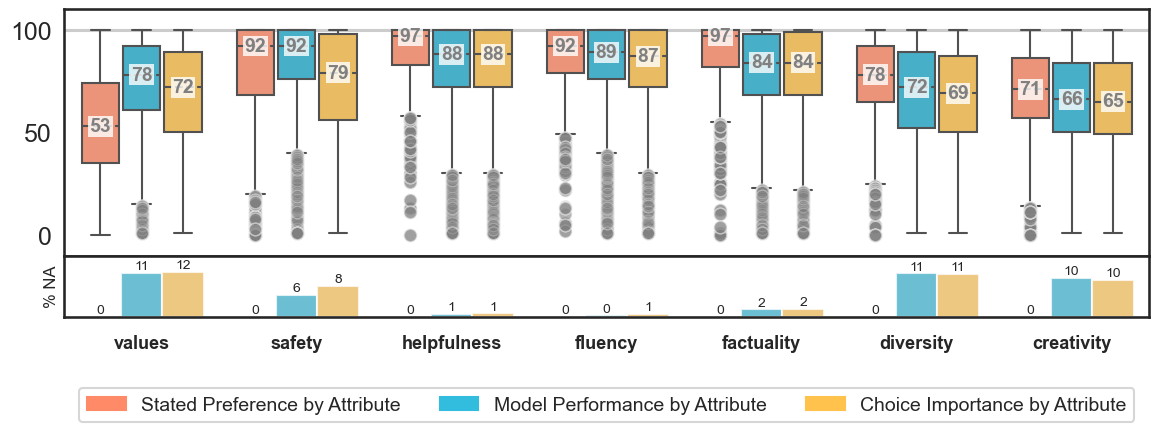

In [24]:
df_dict = {
    "stated_prefs": df[[c for c in df.columns if "personalis" not in c]],
    "performance_attributes": df,
    "choice_attributes": df,
}

legend_dict = {
    "stated_prefs": "Stated Preference by Attribute",
    "performance_attributes": "Model Performance by Attribute",
    "choice_attributes": "Choice Importance by Attribute",
}
title = "Comparison of behaviour attributes in three settings"
plot_box_combined_with_nans(df_dict, title, legend_dict, (14, 4), plot_type="box")

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_68248/2855093761.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontweight="semibold", fontsize=13)
/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_68248/2855093761.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, fontweight="semibold", fontsize=13)


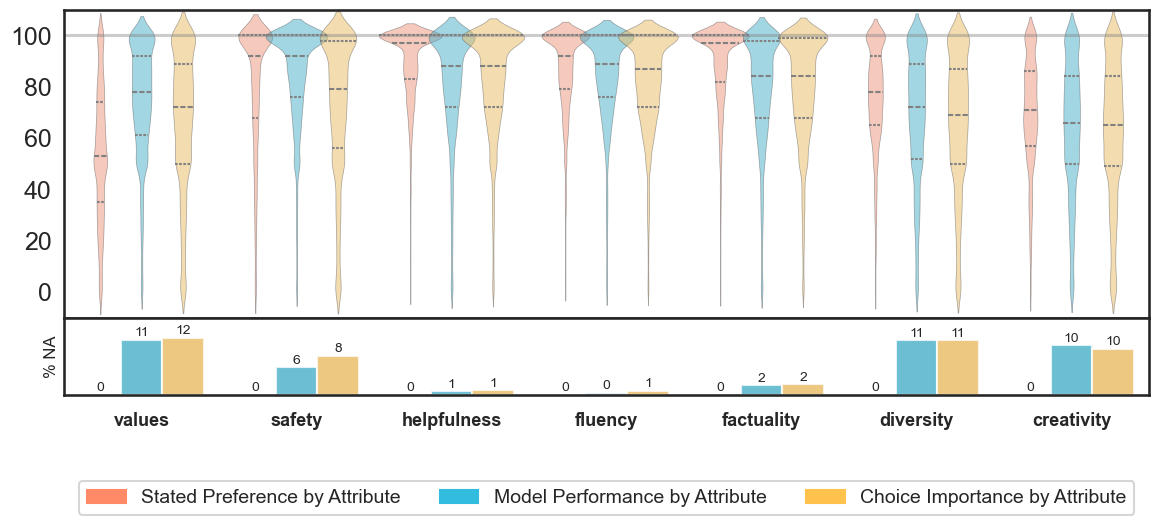

In [25]:
plot_box_combined_with_nans(df_dict, title, legend_dict, (14, 5), plot_type="violin")

## Other Text

What do people list as "other"?

In [29]:
# Collect all "other" text (only option in the survey)
survey = data_dict["survey"]
nested_columns = ["stated_prefs"]
survey = unnest_columns(survey, nested_columns)
other_text = survey[[c for c in survey.columns if "other_text" in c]].dropna()

print(f"Number of participants using other: {len(other_text)}")

# Print a sample
for i in range(5):
    print(other_text.iloc[i].values)

# Save to clipboard for analysis elsewhere
other_text.to_clipboard(index=False)

Number of participants using other: 332
['does no harm']
['does not politicize.']
['Everyday been updated with new knowledge']
['its confidential']
["isn't racist and doesn't judge my questions"]
